In [13]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import glob
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt
# import holoviews as hv
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from pandarallel import pandarallel

# Calculating Connectivity Between Channels

It seems my task is much easier than I previously thought. There are designated recordings for my 4 periods of interested already cleaned and labelled by Derek and Graham. Bless.

Goal for this section's exploration: calculate ISH across 4 periods for 1 patient.
1. Find 4 recordings for patient
1. Calc Connectivity (PDC) for each recording
1. Im show some of those recordings
1. calculate inward-outward strengh for 4 periods - ISH
1. BONUS: Redo 1-4 with cross spectral coherence connectivity from the French

## Flow Between States

In [9]:
tst_df = peri_df[peri_df.eventID == 1]
tst_dict = dict(zip(tst_df.period, tst_df.window_designations))
np.array(list(tst_dict.keys()))

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


array([], dtype=float64)

In [3]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/z_flow'
files = glob.glob(os.path.join(DATA_DIR, "peri_ictal_flow_*pat*.csv"))
grp_flow_dfs = []
check_list = []
for f in files:
    if "Spat18" in f or "Spat17" in f or "Epat20" in f:
        continue
    peri_df = pd.read_csv(f).rename(columns={'window_designationas':'window_designations'})
    # try:
    peri_event_df = center_onset(peri_df)
    grp_flow_dfs.append(peri_event_df)
    # except IndexError as e:
    #     print(f) 
    #     check_list.append(f)
grp_flow_dfs = pd.concat(grp_flow_dfs)
# flow_df = pd.read_csv(os.path.join(DATA_DIR,f))
# flow_df.columns = ['source', 'target', 'value', 'period', 'window_designations', 'eventID',
#        'patID', 'sz_type']
# flow_df = center_onset(flow_df)

/tmp/ipykernel_750014/3708897540.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f).rename(columns={'window_designationas':'window_designations'})
/tmp/ipykernel_750014/3708897540.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f).rename(columns={'window_designationas':'window_designations'})
/tmp/ipykernel_750014/3708897540.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f).rename(columns={'window_designationas':'window_designations'})
/tmp/ipykernel_750014/3708897540.py:8: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  peri_df = pd.read_csv(f).rename(columns={'window_designationas':'window_designations'})
/tmp/ipykernel_750014/3708897540.py:8: DtypeWarning: Columns (6) have mixed types. S

ValueError: Length mismatch: Expected axis has 9 elements, new values have 8 elements

In [4]:
grp_flow_dfs

,win_label,win_sz_st_end,sz_end,win_sz_centered,source,target,value,period,window_designations,freq_band,eventID,patID,sz_type
202164,interictal,-595.0,123,-595,soz,soz,0.314390,0,0.0_0.0_0.0,delta,5,Epat02,FBTC
202165,interictal,-595.0,123,-595,soz,nz,-0.165058,0,0.0_0.0_0.0,delta,5,Epat02,FBTC
202166,interictal,-595.0,123,-595,nz,soz,-0.646267,0,0.0_0.0_0.0,delta,5,Epat02,FBTC
202167,interictal,-595.0,123,-595,nz,nz,-0.262016,0,0.0_0.0_0.0,delta,5,Epat02,FBTC
202168,interictal,-595.0,123,-595,soz,soz,-0.151369,0,0.0_0.0_0.0,theta,5,Epat02,FBTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31387,post_ictal,623.0,118,712,nz,nz,-1.061127,1307,2.0_2.0_2.0,gamma_l,1,Spat53,FBTC
31388,post_ictal,623.0,118,712,soz,soz,NaN,1307,2.0_2.0_2.0,gamma_H,1,Spat53,FBTC
31389,post_ictal,623.0,118,712,soz,nz,-0.658073,1307,2.0_2.0_2.0,gamma_H,1,Spat53,FBTC
31390,post_ictal,623.0,118,712,nz,soz,-1.890306,1307,2.0_2.0_2.0,gamma_H,1,Spat53,FBTC


In [4]:
grp_flow_dfs.dropna()

,win_label,win_sz_st_end,sz_end,win_sz_centered,source,target,value,period,window_designations,freq_band,eventID,patID,sz_type
109116,interictal,-595.0,108.0,-595.0,soz,soz,0.138257,0,0.0_0.0_0.0,delta,3,Epat02,FBTC
109117,interictal,-595.0,108.0,-595.0,soz,nz,0.065549,0,0.0_0.0_0.0,delta,3,Epat02,FBTC
109118,interictal,-595.0,108.0,-595.0,nz,soz,0.093073,0,0.0_0.0_0.0,delta,3,Epat02,FBTC
109119,interictal,-595.0,108.0,-595.0,nz,nz,0.070707,0,0.0_0.0_0.0,delta,3,Epat02,FBTC
109120,interictal,-595.0,108.0,-595.0,soz,soz,0.181559,0,0.0_0.0_0.0,theta,3,Epat02,FBTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
109111,post_ictal,623.0,103.0,697.0,pz,soz,0.279195,1292,2.0_2.0_2.0,gamma_H,11,Epat02,FIAS
109112,post_ictal,623.0,103.0,697.0,pz,pz,0.063928,1292,2.0_2.0_2.0,gamma_H,11,Epat02,FIAS
109113,post_ictal,623.0,103.0,697.0,pz,nz,0.067431,1292,2.0_2.0_2.0,gamma_H,11,Epat02,FIAS
109114,post_ictal,623.0,103.0,697.0,nz,pz,0.061505,1292,2.0_2.0_2.0,gamma_H,11,Epat02,FIAS


In [5]:
pandarallel.initialize()


INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [6]:
grp_flow_dfs['src_trgt'] = grp_flow_dfs.parallel_apply(lambda x : x['source']+ "_"+x['target'], axis=1)
#nz_df = flow_df[flow_df.src_trgt.isin(['nz_soz','nz_pz'])]
#nz_df

In [7]:
# grp_flow_dfs['src_trgt'] = grp_flow_dfs.apply(lambda x : x['source']+ "_"+x['target'], axis=1)

In [19]:
tmp_df = grp_flow_dfs[grp_flow_dfs.freq_band=='alpha']
peri_stats_df = tmp_df[['src_trgt','value','patID','win_sz_st_end']].groupby(['patID','src_trgt', 'win_sz_st_end',]).mean().reset_index()
peri_stats_df.shape[0]

746028

In [15]:

COLOR_MAP['niz_soz'] = COLOR_MAP['soz']
COLOR_MAP['nz_soz'] = COLOR_MAP['soz']
COLOR_MAP['niz_pz'] = COLOR_MAP['pz']
COLOR_MAP['nz_pz'] = COLOR_MAP['pz']
COLOR_MAP['niz_niz'] = COLOR_MAP['nz']
COLOR_MAP['nz_nz'] = COLOR_MAP['nz']

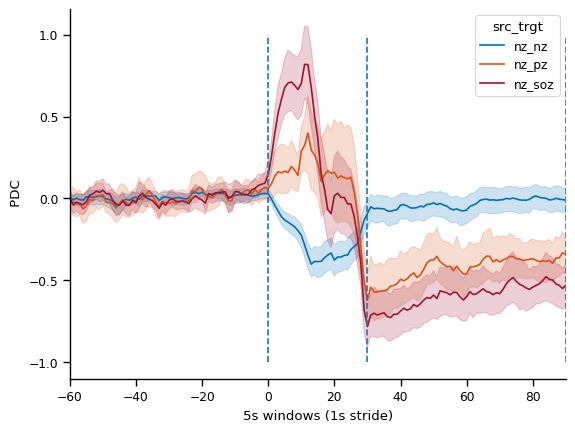

In [20]:
plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
plot_df = plot_df[plot_df.src_trgt.isin(['nz_nz', 'nz_pz', 'nz_soz'])]

with sns.plotting_context("paper"):
    ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt',palette=COLOR_MAP)
    ax.vlines(x = [-60,0, 30, 90], ymin = -1, ymax = 1,linestyles ='dashed')
    plt.xlim(-60,90)
    plt.xlabel("5s windows (1s stride)")
    plt.ylabel(" PDC")
    sns.despine()
    plt.savefig("../viz/nz_flow_z.pdf",transparent=True)
# There are a lot of regions labelled NIZ that end up "seized" during the ic

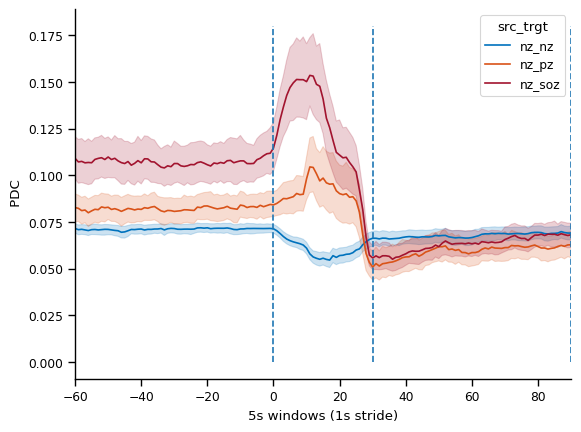

In [8]:
plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
plot_df = plot_df[plot_df.src_trgt.isin(['nz_nz', 'nz_pz', 'nz_soz'])]
with sns.plotting_context("paper"):
    ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt',palette=COLOR_MAP)
    ax.vlines(x = [-60,0, 30, 90], ymin = 0, ymax = .18,linestyles ='dashed')
    plt.xlim(-60,90)
    plt.xlabel("5s windows (1s stride)")
    plt.ylabel(" PDC")
    sns.despine()
    plt.savefig("../viz/nz_flow.pdf",transparent=True)
# There are a lot of regions labelled NIZ that end up "seized" during the ictal 


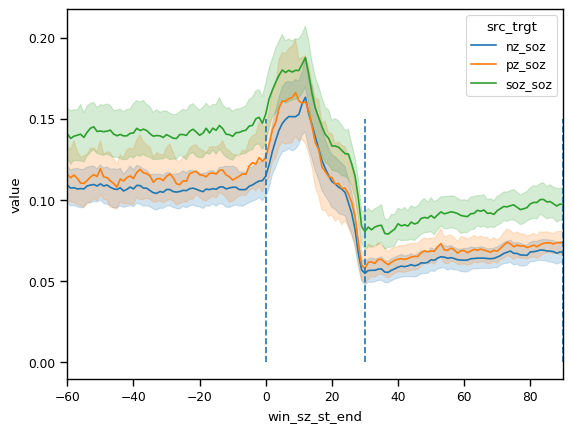

In [9]:
plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
plot_df = plot_df[plot_df.src_trgt.isin(['soz_soz', 'pz_soz', 'nz_soz'])]
with sns.plotting_context("paper"):
    ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt')
    ax.vlines(x = [-60,0, 30, 90], ymin = 0, ymax = .15,linestyles ='dashed')
    plt.xlim(-60,90)

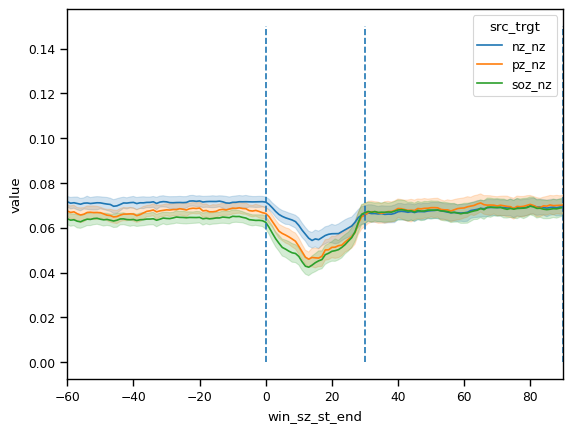

In [11]:
plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
plot_df = plot_df[plot_df.src_trgt.isin(['pz_nz', 'soz_nz', 'nz_nz'])]
with sns.plotting_context("paper"):
    ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt')
    ax.vlines(x = [-60,0, 30, 90], ymin = 0, ymax = .15,linestyles ='dashed')
    plt.xlim(-60,90)

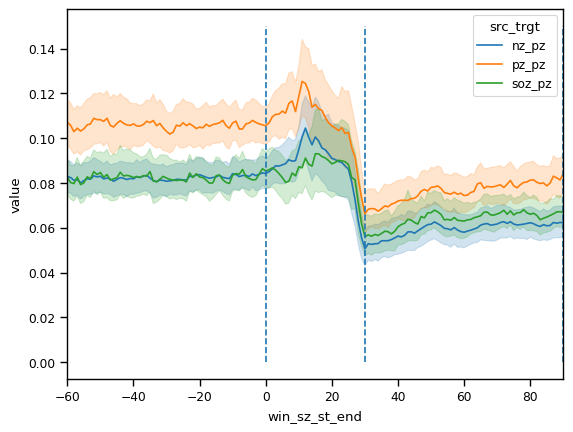

In [12]:
plot_df = peri_stats_df[['src_trgt', 'win_sz_st_end','value']]
plot_df = plot_df[plot_df.src_trgt.isin(['pz_pz', 'soz_pz', 'nz_pz'])]
with sns.plotting_context("paper"):
    ax = sns.lineplot(plot_df, x='win_sz_st_end', y='value',hue='src_trgt')
    ax.vlines(x = [-60,0, 30, 90], ymin = 0, ymax = .15,linestyles ='dashed')
    plt.xlim(-60,90)

In [7]:
band_df = flow_df[flow_df.band == 'gamma_H']
prev_period = ""
flow_stats_df = []
group_level_df =[]
for period in PERIOD:
    #group periods and fix source target labelling
    period_df = band_df[band_df.period == period]
    if prev_period !='':
        period_df['source'] = period_df.apply(lambda x: x['source'] +'_'+prev_period, axis=1)
    period_df['target'] = period_df.apply(lambda x: x['target'] +'_'+period, axis=1)
    prev_period = period

    #get per period statistics
    #first group within subjects
    group_stats_flow_df = period_df[['source','target','subj','value']].groupby(['source','target','subj']).mean()
    group_stats_flow_df = group_stats_flow_df.reset_index()
    group_level_df.append(group_stats_flow_df)
    # stats across groups now
    summary_df = group_stats_flow_df[['source','target','value']].groupby(['source','target']).mean().reset_index()


    flow_stats_df.append(summary_df)

flow_stats_df = pd.concat(flow_stats_df)
group_level_df = pd.concat(group_level_df)


/tmp/ipykernel_24915/3806023537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['target'] = period_df.apply(lambda x: x['target'] +'_'+period, axis=1)
/tmp/ipykernel_24915/3806023537.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_df['source'] = period_df.apply(lambda x: x['source'] +'_'+prev_period, axis=1)
/tmp/ipykernel_24915/3806023537.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [8]:
group_level_df

,source,target,subj,value
0,nz,nz_inter,Epat02,61.643549
1,nz,nz_inter,Epat03,58.767143
2,nz,nz_inter,Epat04,69.977421
3,nz,nz_inter,Epat06,59.521534
4,nz,nz_inter,Epat08,23.667507
...,...,...,...,...
535,soz_ictal,soz_post,Spat50,0.411503
536,soz_ictal,soz_post,Spat51,13.157351
537,soz_ictal,soz_post,Spat52,0.708524
538,soz_ictal,soz_post,pat11,0.000000


In [9]:
from scipy.stats import f_oneway
nz_groups = group_level_df[group_level_df.target.isin(['nz_inter','nz_pre','nz_ictal','nz_post'])]
nzinter = nz_groups[nz_groups.target =='nz_inter'].value
nzpre = nz_groups[nz_groups.target =='nz_pre'].value
nzictal = nz_groups[nz_groups.target =='nz_ictal'].value
nzpost = nz_groups[nz_groups.target =='nz_post'].value
F, p = f_oneway(nzinter, nzpre, nzictal, nzpost)
print(f"F values: {F}")
print(f"p values: {p}")

F values: 0.634051377950704
p values: 0.593215585556679


In [10]:

pz_groups = group_level_df[group_level_df.target.isin(['pz_inter','pz_pre','pz_ictal','pz_post'])]
pzinter = pz_groups[pz_groups.target =='pz_inter'].value
pzpre = pz_groups[pz_groups.target =='pz_pre'].value
pzictal = pz_groups[pz_groups.target =='pz_ictal'].value
pzpost = pz_groups[pz_groups.target =='pz_post'].value
F, p = f_oneway(pzinter, pzpre, pzictal, pzpost)
print(f"F values: {F}")
print(f"p values: {p}")

F values: 0.26054736574445403
p values: 0.8538244183720844


In [11]:

soz_groups = group_level_df[group_level_df.target.isin(['soz_inter','soz_pre','soz_ictal','soz_post'])]
sozinter = soz_groups[soz_groups.target =='soz_inter'].value
sozpre = soz_groups[soz_groups.target =='soz_pre'].value
sozictal = soz_groups[soz_groups.target =='soz_ictal'].value
sozpost = soz_groups[soz_groups.target =='soz_post'].value
F, p = f_oneway(sozinter, sozpre, sozictal, sozpost)
print(f"F values: {F}")
print(f"p values: {p}")

F values: 6.009158792005015
p values: 0.00047985032325588244


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Sankey   [source,target]   (value)
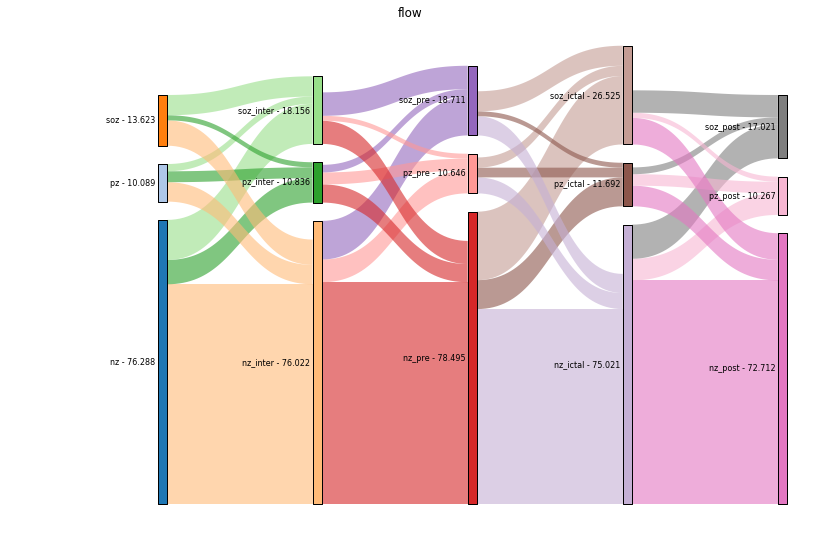

In [28]:
# hv.extension('matplolib')
# sankey = hv.Sankey(flow_stats_df, label="flow")
# sankey.opts(label_position='left', edge_color='target', node_color='index',cmap='tab20')
# # hv.save(sankey, "../viz/soz_flow.pdf", fmt='pdf')

## Plottin Directed Graphs

In [100]:
flow_stats_df['period'] = flow_stats_df.target.apply(lambda x: x.split("_")[1])
flow_df = flow_stats_df
flow_df.source = flow_df.source.apply(lambda x : x.split("_")[0])
flow_df.target = flow_df.target.apply(lambda x : x.split("_")[0])
flow_df

,source,target,value,period
0,nz,nz,58.993035,inter
1,nz,pz,6.527068,inter
2,nz,soz,10.767942,inter
3,pz,nz,5.208995,inter
4,pz,pz,2.932386,inter
5,pz,soz,1.947723,inter
6,soz,nz,6.805295,inter
7,soz,pz,1.376816,inter
8,soz,soz,5.440740,inter
0,nz,nz,59.543089,pre


,source,target,value
0,nz_inter,nz,59.543089
1,nz_inter,pz,6.110856
2,nz_inter,soz,10.368323
3,pz_inter,nz,4.886424
4,pz_inter,pz,3.206139
5,pz_inter,soz,2.042328
6,soz_inter,nz,6.213590
7,soz_inter,pz,1.328871
8,soz_inter,soz,6.300380


In [103]:
period_flow_df

,source,target,value,period
0,nz,nz,58.993035,inter
1,nz,pz,6.527068,inter
2,nz,soz,10.767942,inter
3,pz,nz,5.208995,inter
4,pz,pz,2.932386,inter
5,pz,soz,1.947723,inter
6,soz,nz,6.805295,inter
7,soz,pz,1.376816,inter
8,soz,soz,5.440740,inter


In [118]:
PERIOD

['inter', 'pre', 'ictal', 'post']

[19.664345069982012, 2.1756893398872483, 3.5893140476490895, 1.7363315182483843, 0.9774618563175216, 0.6492409369573793, 2.2684317851045455, 0.45893870483958543, 1.813580074347566]


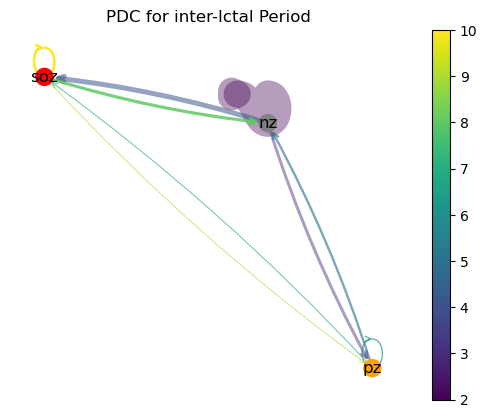

In [136]:
import networkx as nx

seed = 1640


for period in [PERIOD[0]]:
    period_flow_df =  flow_df[flow_df.period==period].drop('period',axis=1)
    edge_list = [(src, tgt, {'weight':val}) for src, tgt, val in period_flow_df.values]
    G, pos = setup_graph(edge_list, seed)
    out_f = f'PDC_{period}_flow.pdf'
    weights = []
    for e in G.edges:
        weights.append(G[e[0]][e[1]][0]['weight']/3)
    print(weights)
    plot_graph(G, pos, weights, out_f)
    plt.title(f'PDC for {period}-Ictal Period')
    break
    



In [111]:
out_f

'post_flow.pdf'

In [24]:
viz_df

,source,target,value
0,nz,nz,58.993035
1,nz,pz,6.527068
2,nz,soz,10.767942
3,pz,nz,5.208995
4,pz,pz,2.932386
5,pz,soz,1.947723
6,soz,nz,6.805295
7,soz,pz,1.376816
8,soz,soz,5.440740


In [81]:
node_labels = [ n for n in G.nodes]
node_labels

['nz', 'pz', 'soz']

In [120]:
#render color plots

# def get_flow_df(full_flow_df, period):
#     viz_df = full_flow_df[full_flow_df.target.isin([f'nz_{period}', f'pz_{period}',f'soz_{period}'])]
#     viz_df.target = viz_df.target.apply(lambda x: x.split("_")[0])
#     return viz_df

def setup_graph(edge_list, seed):

    G = nx.MultiDiGraph()
    G.add_edges_from(edge_list)
    pos = nx.spring_layout(G, seed=seed)
    return G, pos

def plot_graph(G, pos, weights, out_f, cmap = plt.cm.viridis, n_size=150):

    #setup
    node_sizes = [n_size  for i in range(len(G))]
    M = G.number_of_edges()
    edge_colors = range(2, M + 2)
    edge_alphas = [(5 + i) / (M + 4) for i in range(M)]


    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=['gray','orange','red'])
    nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(
        G,
        pos,
        arrows=True,
        node_size=node_sizes,
        arrowstyle="->",
        arrowsize=10,
        edge_color=edge_colors,
        edge_cmap=cmap,
        width=weights,
        connectionstyle='arc3, rad=0.05'
    )
    # set alpha value for each edge
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])
    pc = matplotlib.collections.PatchCollection(edges, cmap=cmap)
    pc.set_array(edge_colors)

    ax = plt.gca()
    ax.set_axis_off()
    plt.colorbar(pc, ax=ax)
    plt.savefig(f'../viz/{out_f}')



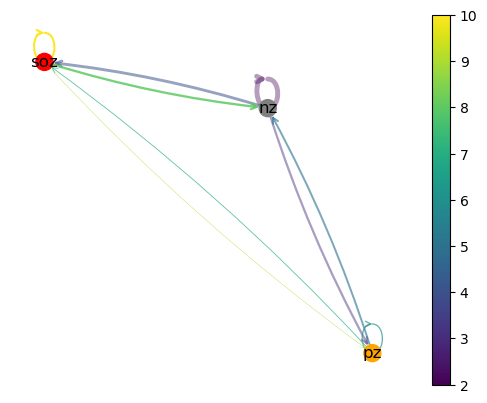

In [85]:
plot_graph(G, pos, node_sizes, 'inter_conn.pdf')